# Grafici

In [1]:
import pandas as pd
import os
import seaborn as sns


heade = ['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed', 'Mrem', 'Srem', 'esca_v', 'Mcluster', 'gen']

path_data = '/home/gabriele/data/'
dyn = '/Dyn/' # Direi che così è facilmente customizzabile per come ogni autistic* si è sistemato i files.
cols = [1,2,3,4,9,13,15,16,17,25,27]
print(len(cols), len(heade))

11 11


In [2]:
def extractor(path_data, cluster):
    data = pd.DataFrame()
    wichcluster = os.listdir(path_data)
    #print(wichcluster)
    if cluster == 'gc':
        cluster = wichcluster[2]
    if cluster == 'nsc':
        cluster = wichcluster[1]
    if cluster == 'ysc':
        cluster = wichcluster[0]
    for i in os.listdir(path_data + cluster + dyn):
        #print(i)
        name = path_data + cluster + dyn + str(i) + '/nth_generation.txt'
        #print(name)
        dataZ=pd.read_csv(name, delimiter=' ', skiprows=1, usecols=cols, names=heade)#, names=heade)
        #dataZ.drop(dataZ.columns[[0, 5, 6, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 24, 26]], axis=1, inplace=True)
        #dataZ.columns = heade
        dataZ['Z'] = float(i)
        data = pd.concat([data, dataZ])
    return data

In [3]:
#vari cluster

dysc = extractor(path_data, 'ysc')
dgc = extractor(path_data, 'gc')
dnsc = extractor(path_data, 'nsc')

In [55]:
#controllo se ci sono NaN
dysc.isna().sum().sum()
dgc.isna().sum().sum()
dnsc.isna().sum().sum()

0

Alcuni BBHs hanno Mrem e Srem nullo e il t_elapsed è massimo (suppongo sia il tempo massimo della simulazione che li ha generati). Se questi dati non vanno scartati per qualche motivo da discutere (errori o interruzione della simulazione), possiamo ipotizzare che non abbiano mai mergiato (vorrei capire perché risulta comunque una generazione >=2, penso che la gen venga settata a 2 di base). Quindi divido in due subset, uno che contiene quelli mergiati una sola volta e uno che contiene quelli mai mergiati, per vedere quali caratteristiche hanno un ruolo maggiore nel merging di almeno prima generazione (2g), escludendo quindi anche tutti i BBHs di gen > 2.

In [4]:
#subset non merged

dgc_non_merged = dgc[(dgc['Mrem'])==0]
dysc_non_merged = dysc[(dysc['Mrem'])==0]
dnsc_non_merged = dnsc[(dnsc['Mrem'])==0]

#subset merged di gen = 2

dgc_merged = dgc[(dgc['Mrem'] > 0) & (dgc['gen'] == 2)]
dysc_merged = dysc[(dysc['Mrem'] > 0)  & (dysc['gen'] == 2)]
dnsc_merged = dnsc[(dnsc['Mrem'] > 0)  & (dnsc['gen'] == 2)]

# Analisi e RFC per BBHs che hanno mergiato una volta e BBHs che non hanno mergiato.

GC - merged: 427714, non merged: 4725
YSC - merged: 7175, non merged: 253
NSC - merged: 2579726, non merged: 11790

analisi per GC
bilanciamento del dataset per GC: campionamento da 427714 a 4725 elementi

t-test
M1, p-value: 0.0000, differenza significativa


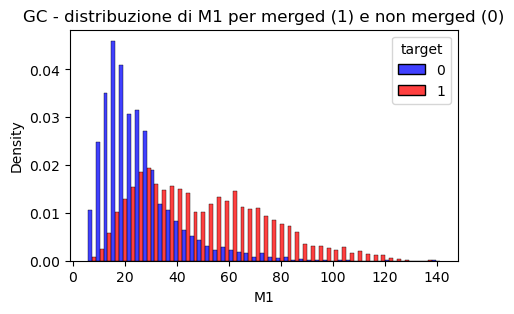

M2, p-value: 0.0000, differenza significativa


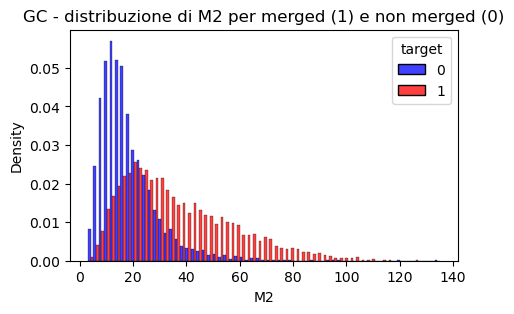

S1, p-value: 0.0023, differenza significativa


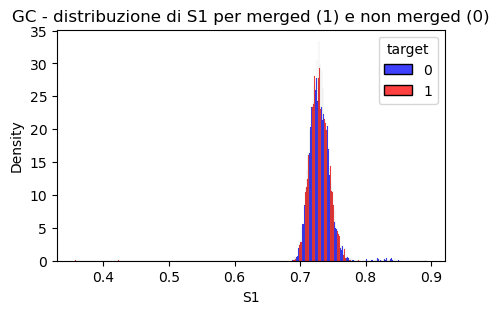

S2, p-value: 0.0000, differenza significativa


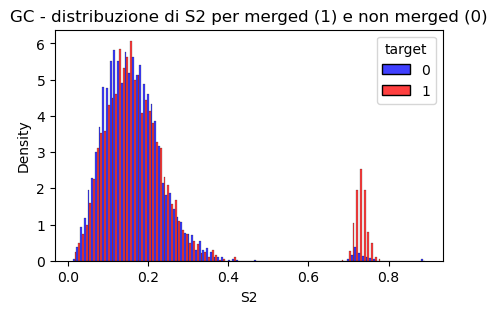

Random Forest Classifier

accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1418
           1       1.00      1.00      1.00      1417

    accuracy                           1.00      2835
   macro avg       1.00      1.00      1.00      2835
weighted avg       1.00      1.00      1.00      2835



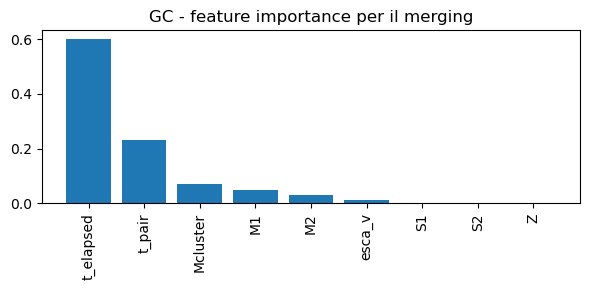


feature importance:
1. t_elapsed: 0.6019
2. t_pair: 0.2329
3. Mcluster: 0.0712
4. M1: 0.0477
5. M2: 0.0301
6. esca_v: 0.0132
7. S1: 0.0014
8. S2: 0.0010
9. Z: 0.0006

analisi per YSC
bilanciamento del dataset per YSC: campionamento da 7175 a 253 elementi

t-test
M1, p-value: 0.0000, differenza significativa


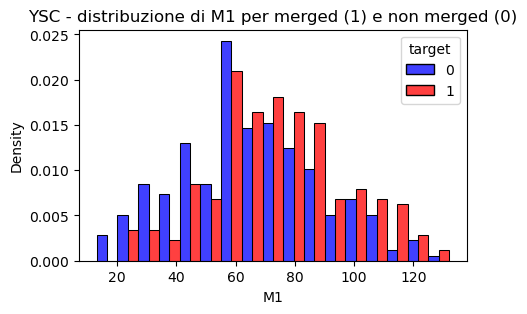

M2, p-value: 0.0000, differenza significativa


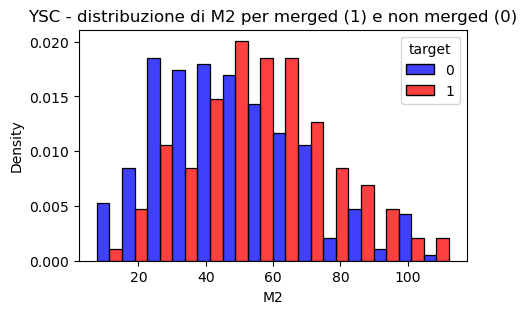

S1, p-value: 0.6286, differenza non significativa


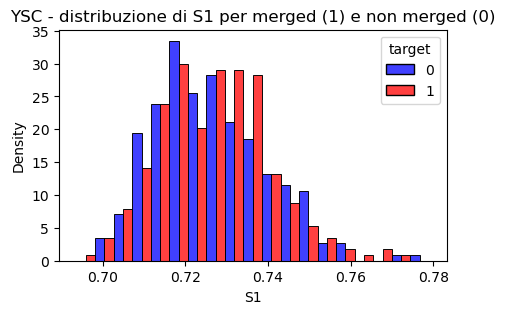

S2, p-value: 0.0810, differenza non significativa


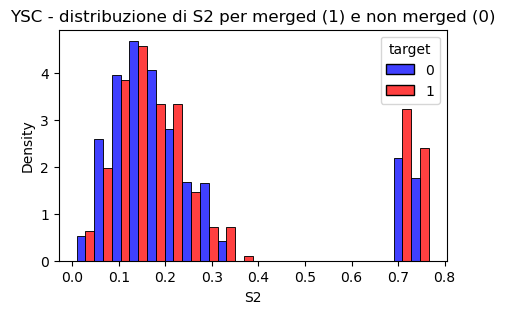

Random Forest Classifier

accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        76
           1       1.00      1.00      1.00        76

    accuracy                           1.00       152
   macro avg       1.00      1.00      1.00       152
weighted avg       1.00      1.00      1.00       152



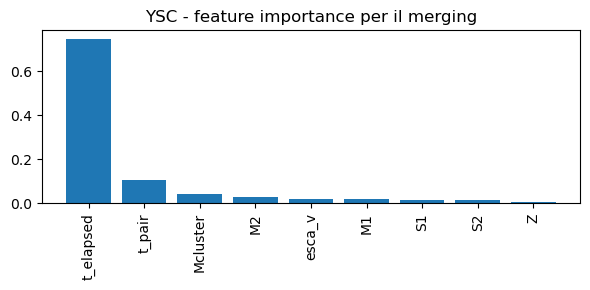


feature importance:
1. t_elapsed: 0.7470
2. t_pair: 0.1066
3. Mcluster: 0.0417
4. M2: 0.0287
5. esca_v: 0.0214
6. M1: 0.0194
7. S1: 0.0157
8. S2: 0.0140
9. Z: 0.0054

analisi per NSC
bilanciamento del dataset per NSC: campionamento da 2579726 a 11790 elementi

t-test
M1, p-value: 0.0000, differenza significativa


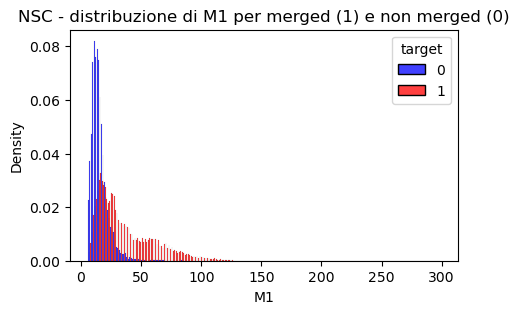

M2, p-value: 0.0000, differenza significativa


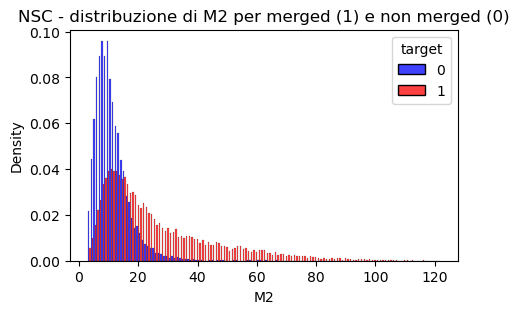

S1, p-value: 0.0000, differenza significativa


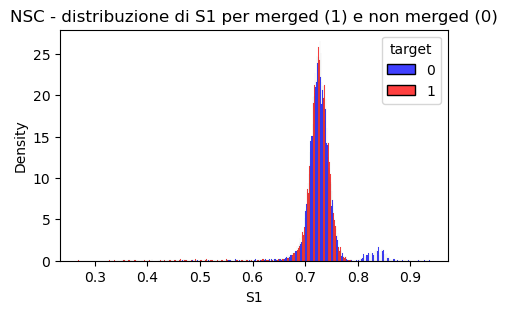

S2, p-value: 0.0000, differenza significativa


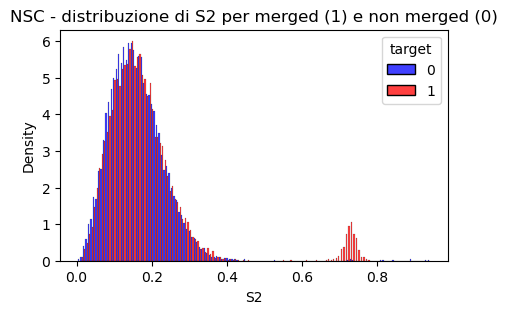

Random Forest Classifier

accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3537
           1       1.00      1.00      1.00      3537

    accuracy                           1.00      7074
   macro avg       1.00      1.00      1.00      7074
weighted avg       1.00      1.00      1.00      7074



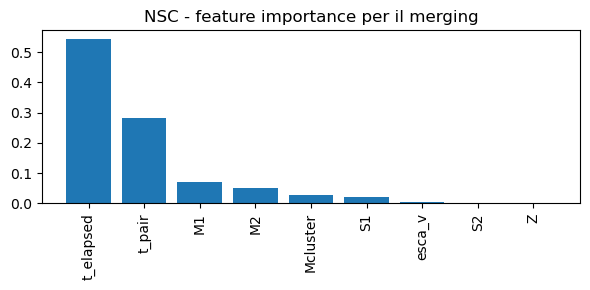


feature importance:
1. t_elapsed: 0.5444
2. t_pair: 0.2810
3. M1: 0.0691
4. M2: 0.0492
5. Mcluster: 0.0277
6. S1: 0.0219
7. esca_v: 0.0061
8. S2: 0.0004
9. Z: 0.0003


In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import ttest_ind
from sklearn.utils import resample
from IPython.display import display, Markdown


#dimensioni dei due subset
print(f"GC - merged: {len(dgc_merged)}, non merged: {len(dgc_non_merged)}")
print(f"YSC - merged: {len(dysc_merged)}, non merged: {len(dysc_non_merged)}")
print(f"NSC - merged: {len(dnsc_merged)}, non merged: {len(dnsc_non_merged)}")

#analisi per i vari cluster
for cluster_name, merged_df, non_merged_df in [
    ('GC', dgc_merged, dgc_non_merged),
    ('YSC', dysc_merged, dysc_non_merged),
    ('NSC', dnsc_merged, dnsc_non_merged)
    ]:
    print(f"\nanalisi per {cluster_name}")
    
    merged_df_for_analysis = merged_df.copy()
    non_merged_df_for_analysis = non_merged_df.copy()
    
    #bilanciamento dataset ttest(cambiare seed)
    print(f"bilanciamento del dataset per {cluster_name}: campionamento da {len(merged_df)} a {len(non_merged_df)} elementi\n")
    merged_df_for_analysis = resample(merged_df, n_samples=len(non_merged_df), random_state=42)
    
    #ttest
    features_ttest = ['M1', 'M2', 'S1', 'S2']
    p_value = 0.01
    print("\033[1mt-test\033[0m")
    for feature in features_ttest:
        merged_values = merged_df_for_analysis[feature].values
        non_merged_values = non_merged_df_for_analysis[feature].values
        stat, p = ttest_ind(merged_values, non_merged_values, equal_var=False)
        significance = "significativa" if p < p_value else "non significativa"
        print(f"{feature}, p-value: {p:.4f}, differenza {significance}")
        
        #plot distribuzioni 
        plot_df = pd.concat([merged_df_for_analysis, non_merged_df_for_analysis])
        plot_df['target'] = np.where(plot_df['Mrem'] > 0, 1, 0)
        plt.figure(figsize=(5, 3))
        sns.histplot(data=plot_df, x=feature, hue='target', 
                     multiple='dodge', palette=['blue', 'red'],
                     stat='density', common_norm=False)
        plt.title(f'{cluster_name} - distribuzione di {feature} per merged (1) e non merged (0)')
        plt.show()
        
        
    #RFC
    #ricombino i df e creo il target
    print("\033[1mRandom Forest Classifier\033[0m")
    
    df_combined = pd.concat([merged_df_for_analysis, non_merged_df_for_analysis])
    df_combined['target'] = np.where(df_combined['Mrem'] > 0, 1, 0) #1 merged, 0 non merged
    df_model = df_combined.copy()
    features = ['M1', 'M2', 'S1', 'S2', 't_pair', 't_elapsed', 'esca_v', 'Mcluster', 'Z'] 
    X = df_model[features]
    y = df_model['target']
    
    #addestramento modello
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    #valutazione modello
    y_pred = clf.predict(X_test)
    print(f"\naccuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    
    #importanza features
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(6, 3))
    plt.title(f'{cluster_name} - feature importance per il merging')
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    print("\nfeature importance:")
    for i in range(X.shape[1]):
        print(f"{i+1}. {features[indices[i]]}: {importances[indices[i]]:.4f}")

giustamente (?) per tutti e tre i tipi di cluster il tempo totale e il tempo di pairing sono importanti perché ovviamente se dai un tempo infinito ai due BHs prima o poi mergiano. La massa del cluster sembra essere la 'prima' vera feature importante, almeno per YSC e GC, forse perché legata al fatto che è la grandezza che 'trattiene' il BH finale dallo sfuggire a seguito del kick. Poi abbiamo le masse dei BHs iniziali.

todo: RFC multilabel per BBHs di gen>2